In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchonn as onn
from torchonn.models import ONNBaseModel
from    torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.transforms as transforms
import scipy.stats as stats
from copy import deepcopy
from PIL import Image, ImageFilter
from    MiniImagenet import MiniImagenet
import os

2023-08-01 23:10:48,352 - butterfly_op.py[line:23] - WARNING: Import universal_cuda fail
2023-08-01 23:10:48,353 - butterfly_op.py[line:27] - WARNING: Import hadamard_cuda fail
2023-08-01 23:10:48,355 - matrix_parametrization.py[line:23] - WARNING: Cannot import matrix_parametrization_cuda. Decomposers can only work on CPU mode


In [2]:
from learner import Learner
config = [
        ('conv2d', [32, 3, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [32]),
        ('max_pool2d', [2, 2, 0]),
        ('conv2d', [32, 32, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [32]),
        ('max_pool2d', [2, 2, 0]),
        ('conv2d', [32, 32, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [32]),
        ('max_pool2d', [2, 2, 0]),
        ('conv2d', [32, 32, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [32]),
        ('max_pool2d', [2, 1, 0]),
        ('flatten', []),
        ('linear', [5, 32 * 5 * 5])
]

In [3]:
mini = MiniImagenet('/Users/matthewho/Photonic_computing/simphox-notebooks/MAML/miniimagenet/', mode='train', n_way=5, k_shot=1,
                        k_query=15,
                        batchsz=10000, resize=84)
mini_test = MiniImagenet('/Users/matthewho/Photonic_computing/simphox-notebooks/MAML/miniimagenet/', mode='test', n_way=5, k_shot=1,
                        k_query=15,
                        batchsz=100, resize=84)
db = DataLoader(mini, 4, shuffle=True, num_workers=0, pin_memory=True)
db_test = DataLoader(mini_test, 32, shuffle=True, num_workers=0, pin_memory=True)

shuffle DB :train, b:10000, 5-way, 1-shot, 15-query, resize:84
shuffle DB :test, b:100, 5-way, 1-shot, 15-query, resize:84


In [4]:
next(iter(db_test))[0].shape

torch.Size([32, 5, 3, 84, 84])

In [5]:
num_epochs = 100

device = torch.device('cpu')

x_spt, y_spt, x_qry, y_qry = torch.tensor(0), torch.tensor(0), torch.tensor(0), torch.tensor(0)

# loop is just here to access the first element, we break out immediately after
for x_sptc, y_sptc, x_qryc, y_qryc in db_test:
    x_spt, y_spt, x_qry, y_qry = x_sptc, y_sptc, x_qryc, y_qryc
    break


In [6]:
x_spt.shape

torch.Size([32, 5, 3, 84, 84])

In [7]:
def check_accuracy(data, labels, model, idx = 0):
    # print('Checking accuracy on set')   
    num_correct = 0
    num_samples = 0
    num_data_points = data.shape[0]
    
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        x, y = data[idx], labels[idx]
        x = x.to(device=torch.device("cpu"), dtype=torch.float32)  # move to device, e.g. GPU
        y = y.to(device=torch.device("cpu"), dtype=torch.long)
        scores = model(x)
        _, preds = scores.max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        # print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return acc
        
def train(data, labels, model, optimizer, epochs=50, idx = 0):
    model = model.to(device=torch.device("cpu"))  # move the model parameters to CPU/GPU    
    test_accuracies = []
    for e in range(epochs):
        # print(f"Epoch number: {e}")
        x, y = data[idx], labels[idx]
        model.train()  # put model to training mode
        x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
        y = y.to(device=device, dtype=torch.long)

        scores = model(x)
        loss = F.cross_entropy(scores, y)

        # Zero out all of the gradients for the variables which the optimizer
        # will update.
        optimizer.zero_grad()

        # This is the backwards pass: compute the gradient of the loss with
        # respect to each  parameter of the model.
        loss.backward()

        # Actually update the parameters of the model using the gradients
        # computed by the backwards pass.
        
        
        optimizer.step()
        # print('Loss = %.4f' % (loss.item()))
        # print("Train accuracy:")
        # check_accuracy(x_spt_ua, y_spt_ua, model,idx)
        # print("Test accuracy:")
        test_accuracies.append(check_accuracy(x_qry, y_qry, model, idx))
    return test_accuracies

In [8]:
models = [Learner(config) for _ in range(32)]
for i in range(32):
    models[i].load_state_dict(torch.load('miniimagenet_maml.pth').net.state_dict())

In [9]:
lr_list = [0.0001, 0.0005, 0.001, 0.01, 0.05]

scratch_test_accuracies = {}
maml_test_accuracies = {}

print("doing training from scratch accuracies now")

for lr in lr_list:
    models = []
    models = [Learner(config) for _ in range(32)]
    test_accs = []
    for idx in range(32):
        models[idx].eval()
        optimizer = optim.SGD(models[idx].parameters(), lr=lr, momentum=0.9, nesterov=True)
        test_accs.append(train(x_spt, y_spt, models[idx], optimizer, epochs = 50, idx = idx))
    scratch_test_accuracies[str(lr)] = np.average(np.array(test_accs), axis = 0)
    print(f"For LR = {lr}: {scratch_test_accuracies[str(lr)]}")

print("doing maml accuracies now")

for lr in lr_list:
    models = []
    models = [Learner(config) for _ in range(32)]
    for i in range(32):
        models[i].load_state_dict(torch.load('miniimagenet_maml.pth').net.state_dict())
    test_accs = []
    for idx in range(32):
        models[idx].eval()
        optimizer = optim.SGD(models[idx].parameters(), lr=lr, momentum=0.9, nesterov=True)
        test_accs.append(train(x_spt, y_spt, models[idx], optimizer, epochs = 50, idx = idx))
    maml_test_accuracies[str(lr)] = np.average(np.array(test_accs), axis = 0)
    print(f"For LR = {lr}: {maml_test_accuracies[str(lr)]}")

doing training from scratch accuracies now
For LR = 0.0001: [0.18833333 0.19208333 0.19166667 0.19625    0.1975     0.20375
 0.20541667 0.20666667 0.20875    0.20625    0.20833333 0.21083333
 0.2125     0.215      0.21708333 0.21708333 0.2175     0.21833333
 0.21833333 0.22041667 0.22208333 0.22375    0.2225     0.22375
 0.22375    0.22333333 0.22375    0.22333333 0.22333333 0.22333333
 0.22541667 0.22625    0.22583333 0.22541667 0.22541667 0.22541667
 0.22416667 0.22416667 0.22416667 0.225      0.225      0.22458333
 0.22458333 0.22458333 0.22416667 0.22416667 0.22416667 0.22416667
 0.22458333 0.225     ]
For LR = 0.0005: [0.2        0.21083333 0.21625    0.22375    0.22458333 0.23
 0.22833333 0.22958333 0.23166667 0.23666667 0.2375     0.23625
 0.23708333 0.23916667 0.24       0.24166667 0.24291667 0.24333333
 0.24291667 0.24458333 0.24541667 0.24583333 0.24833333 0.24958333
 0.24833333 0.24833333 0.24833333 0.24875    0.24791667 0.2475
 0.24833333 0.24875    0.24875    0.24875    0.

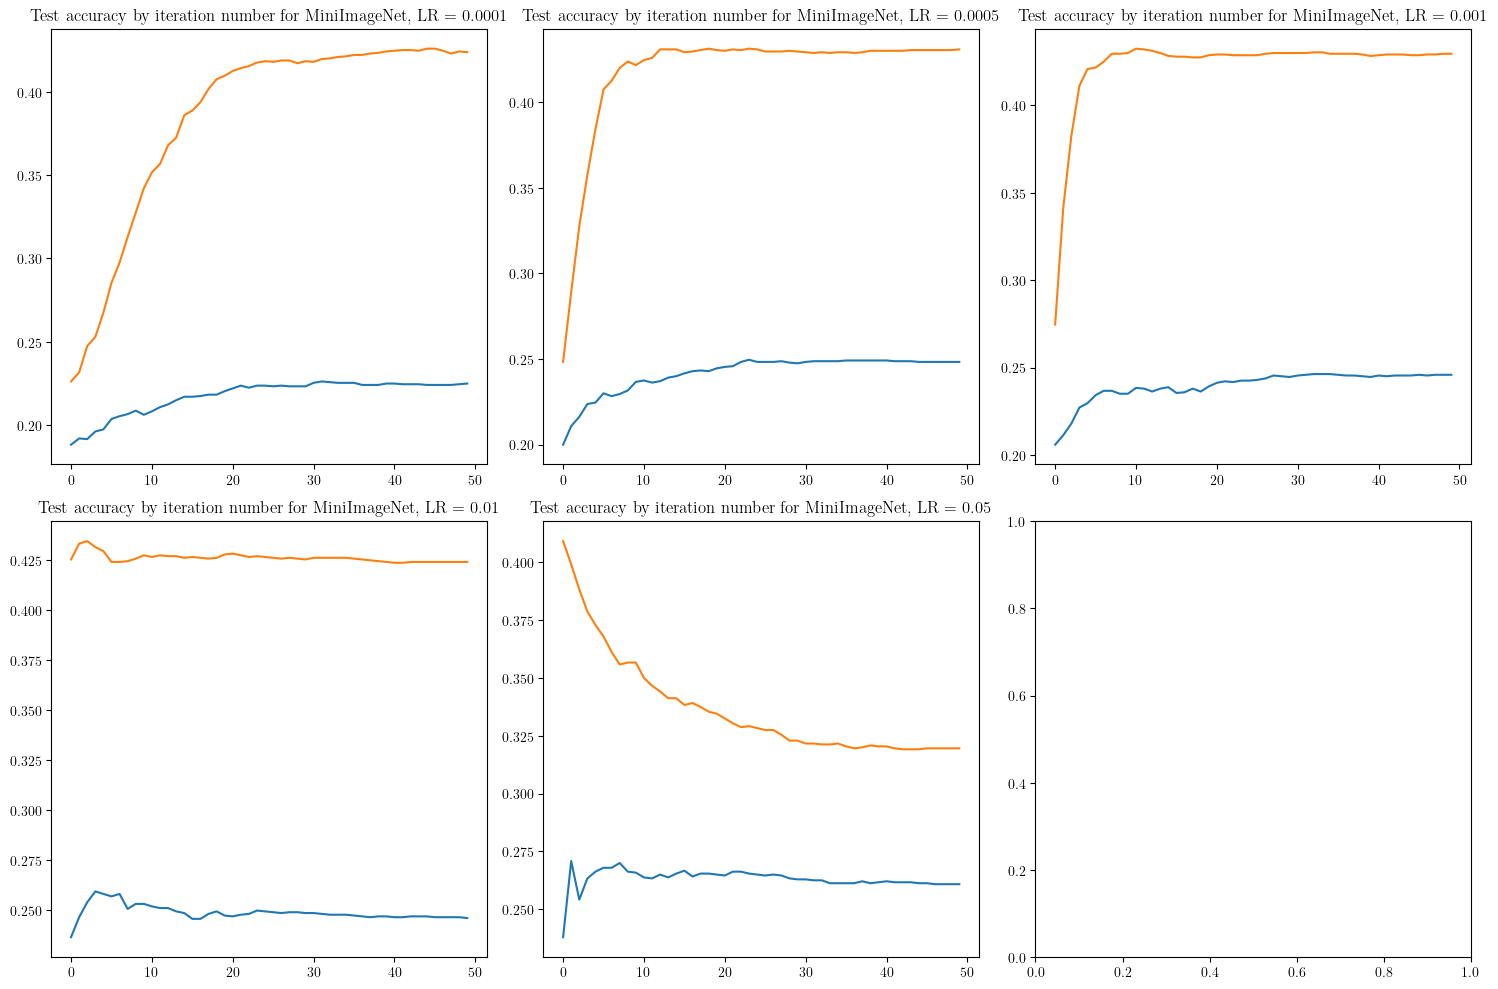

In [12]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for idx, lr in enumerate(lr_list):
    y0 = scratch_test_accuracies[str(lr)]
    y1 = maml_test_accuracies[str(lr)]
    axs[idx // 3, idx % 3].plot(np.array(list(range(len(y0)))), y0)
    axs[idx // 3, idx % 3].plot(np.array(list(range(len(y1)))), y1)
    axs[idx // 3, idx % 3].set_title(f'Test accuracy by iteration number for MiniImageNet, LR = {lr}')

plt.tight_layout()  # Adjust the layout to avoid overlapping titles and labels
plt.savefig('miniimagenet_metalearning_comparison.jpg', format='jpg')
plt.show()

In [16]:
for lr in lr_list:
    print(f"{lr}:")
    print("Scratch:")
    print(scratch_test_accuracies[str(lr)].tolist())
    print()
    print("MAML:")
    print(maml_test_accuracies[str(lr)].tolist())
    print()


0.0001:
Scratch:
[0.18833333333333335, 0.19208333333333333, 0.19166666666666668, 0.19625, 0.19749999999999998, 0.20375, 0.2054166666666667, 0.20666666666666667, 0.20875, 0.20625000000000002, 0.2083333333333333, 0.2108333333333333, 0.21249999999999997, 0.215, 0.21708333333333335, 0.21708333333333338, 0.21750000000000003, 0.21833333333333338, 0.21833333333333338, 0.22041666666666673, 0.2220833333333333, 0.22374999999999998, 0.22249999999999998, 0.22374999999999998, 0.22374999999999998, 0.2233333333333333, 0.22374999999999998, 0.2233333333333333, 0.2233333333333333, 0.2233333333333333, 0.2254166666666666, 0.22624999999999992, 0.22583333333333327, 0.2254166666666666, 0.22541666666666657, 0.22541666666666657, 0.22416666666666657, 0.22416666666666657, 0.22416666666666657, 0.22499999999999992, 0.22499999999999992, 0.22458333333333327, 0.22458333333333327, 0.22458333333333327, 0.2241666666666666, 0.2241666666666666, 0.2241666666666666, 0.2241666666666666, 0.22458333333333325, 0.224999999999999